In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from matplotlib import rcParams
from snownlp import SnowNLP
import re
rcParams['font.sans-serif'] = ['Microsoft YaHei']
rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test.head()

,id,name,description,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,reviews
0,3917,"Beautiful 3 bedroom House in Woodside, Queens",Beautiful 3 bedroom house in the heart of Wood...,Entire home,Woodside,Queens,40.744620,-73.904520,2013-05-07 00:00:00,NaN,NaN,NaN,False,1.0,12.0,"['email', 'phone']",True,True,1,1,0,0,Entire home/apt,6,1.5,1.5 baths,3.0,4.0,"[""Dishwasher"", ""Dining table"", ""Keypad"", ""Smok...",True,29,59,89,89,False,30,90,28,2,0,2022-10-17 00:00:00,2023-09-17 00:00:00,5.00,5.00,4.96,5.00,5.00,4.96,4.96,1.22,Home was perfect and exactly what we needed to...
1,1885,"Queens HDTV Room 13 mins to Manhattan, 3 bath ...",Bright bedroom in the best part of Long Island...,Private room in rental unit,Long Island City,Queens,40.753407,-73.934995,2012-08-11 00:00:00,within an hour,99.0,23.0,False,727.0,1336.0,"['email', 'phone']",True,True,719,0,719,0,Private room,1,3.0,3 shared baths,4.0,1.0,"[""Kitchen"", ""Hot water"", ""Dedicated workspace""...",True,29,59,89,364,False,30,365,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1305,Lovely Bright & Spacious Loft in Brooklyn.,"Our loft is spacious and calm, filled with nat...",Entire loft,Crown Heights,Brooklyn,40.677090,-73.943810,2012-05-14 00:00:00,NaN,NaN,NaN,False,1.0,1.0,"['email', 'phone']",True,True,1,1,0,0,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Kitchen"", ""Hair dryer"", ""Iron"", ""Heating"", ""...",True,29,59,89,89,False,30,365,31,0,0,2021-10-17 00:00:00,2022-10-31 00:00:00,4.94,5.00,4.90,4.90,4.97,4.68,4.90,0.88,I would give this place 10 stars if it were op...
3,19328,Classic Petite Room SB #17 - Furnished Studio,"Extended stay hotel , all rooms are fully furn...",Entire rental unit,Upper West Side,Manhattan,40.795760,-73.971570,2021-04-05 00:00:00,within a day,70.0,37.0,False,36.0,79.0,"['email', 'phone']",True,True,36,18,18,0,Entire home/apt,1,3.0,3 baths,0.0,1.0,"[""Kitchen"", ""Hair dryer"", ""Hot water"", ""Dedica...",True,0,0,0,157,False,30,500,4,3,1,2023-05-29 00:00:00,2024-08-21 00:00:00,4.75,4.50,4.75,5.00,4.50,5.00,4.50,0.26,The front-desk staff was absolutely wonderful ...
4,16511,Petit chalet with secret garden,Small loft type of apartment on ground floor w...,Entire rental unit,Williamsburg,Brooklyn,40.713590,-73.955400,2014-10-07 00:00:00,within a few hours,100.0,75.0,False,1.0,1.0,"['email', 'phone']",True,True,1,1,0,0,Entire home/apt,2,1.0,1 bath,0.0,1.0,"[""Coffee maker: pour-over coffee"", ""Cleaning p...",True,3,12,24,113,False,30,60,157,2,1,2015-02-22 00:00:00,2024-08-31 00:00:00,4.82,4.89,4.69,4.97,4.96,4.94,4.73,1.35,I really enjoyed staying at Kanae's place. It ...


In [4]:
train.isnull().sum()

name                                               0
description                                      387
property_type                                      0
price                                              0
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
host_since                                         0
host_response_time                              2203
host_response_rate                              2203
host_acceptance_rate                            2053
host_is_superhost                                251
host_listings_count                                0
host_total_listings_count                          0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
calculated_host_listings_count                

In [5]:
class SentimentScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sentiment_scores = X['reviews'].fillna('').apply(
            lambda text: SnowNLP(text).sentiments if text else 0.5
        )
        return sentiment_scores.to_frame(name='sentiment_score')

In [6]:
class DistanceFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, locations):
        self.locations = locations
    def fit(self, X, y=None):
        return self
    
    def haversine_distance(self, lat1, lon1, lat2, lon2):
        # 转换为弧度
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371  # 地球半径，单位为公里
        return c * r

    def transform(self, X):
        transformed_data = pd.DataFrame(index=X.index)    
        # 计算到每个位置中心的 Haversine 距离
        for location_name, (lat2, lon2) in self.locations.items():
            transformed_data[f'distance_to_{location_name}'] = X.apply(
                lambda row: self.haversine_distance(row['latitude'], row['longitude'], lat2, lon2), axis=1
            )
        
        return transformed_data

    def get_feature_names_out(self, input_features=None):
        return np.array([f'distance_to_{name}' for name in self.locations.keys()])
    #def get_feature_names(self):
    #    return [f'distance_to_{name}' for name in self.locations.keys()]

In [7]:
class ListTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.unique_values = {}

    def fit(self, X, y=None):
        for col in self.columns:
            # 获取列中的所有唯一值
            self.unique_values[col] = set()
            X[col].dropna().apply(lambda x: self.unique_values[col].update(x))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            # 针对每个列的独热编码
            for value in self.unique_values[col]:
                X_transformed[f"{col}_{value}"] = X_transformed[col].apply(
                    lambda x: 1 if x is not None and value in x else 0
                )
            # 移除原始列
            X_transformed.drop(columns=[col], inplace=True)
        return X_transformed
    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{value}")
        return np.array(feature_names)

In [8]:
class LuxuryFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, luxury_keywords=None):
        if luxury_keywords is None:
            self.luxury_keywords = ['luxury', 'spacious', 'elegant', 'modern', 'exclusive']
        else:
            self.luxury_keywords = luxury_keywords

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = re.compile('|'.join(self.luxury_keywords), re.IGNORECASE)
        is_luxury = X['name'].fillna('') + ' ' + X['description'].fillna('')
        is_luxury = is_luxury.apply(lambda x: 1 if pattern.search(x) else 0)
        return is_luxury.to_frame(name='is_luxury')

    def get_feature_names_out(self, input_features=None):
        return np.array(['is_luxury'])

# Count and detect luxury amenities
class AmenitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, luxury_amenities=None):
        if luxury_amenities is None:
            self.luxury_amenities = ['pool', 'jacuzzi', 'gym', 'sauna', 'hot tub']
        else:
            self.luxury_amenities = luxury_amenities

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        amenities_df = pd.DataFrame(index=X.index)
        # Count total amenities
        amenities_df['num_amenities'] = X['amenities'].fillna('[]').apply(
            lambda x: len(eval(x)) if isinstance(x, str) else 0
        )
        # Detect luxury amenities
        for amenity in self.luxury_amenities:
            amenities_df[f'has_{amenity.replace(" ", "_")}'] = X['amenities'].fillna('[]').apply(
                lambda x: 1 if amenity.lower() in map(str.lower, eval(x)) else 0
            )
        return amenities_df
    def get_feature_names_out(self, input_features=None):
        feature_names = ['num_amenities']
        for amenity in self.luxury_amenities:
            feature_names.append(f'has_{amenity.replace(" ", "_")}')
        return np.array(feature_names)


# Adding the new features to the pipeline
luxury_transformer = Pipeline(steps=[
    ('luxury_features', LuxuryFeatureTransformer())
])

amenities_transformer = Pipeline(steps=[
    ('amenities_features', AmenitiesTransformer())
])

In [9]:
class PositiveReviewTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, positive_words=None):
        if positive_words is None:
            self.positive_words = ['great', 'amazing', 'excellent', 'fantastic', 'wonderful', 'perfect', 'clean', 'comfortable']
        else:
            self.positive_words = positive_words

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = re.compile('|'.join(self.positive_words), re.IGNORECASE)
        positive_reviews = X['reviews'].fillna('').apply(
            lambda text: 1 if pattern.search(text) else 0
        )
        return positive_reviews.to_frame(name='is_positive_review')
    def get_feature_names_out(self, input_features=None):
        return np.array(['is_positive_review'])
        
# Adding the new feature to the pipeline
positive_review_transformer = Pipeline(steps=[
    ('positive_reviews', PositiveReviewTransformer())
])


In [10]:
numeric_features = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','accommodates','bathrooms','bedrooms','beds','availability_30','availability_60','availability_90','availability_365',
'minimum_nights','maximum_nights','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']

categorical_features = ['host_response_time','property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'host_verifications','room_type']#,'amenities']

list_features = ['host_verifications', 'amenities']

geo_features = ['latitude', 'longitude']

locations = {
    'manhattan': (40.7831, -73.9712),
    'brooklyn': (40.6782, -73.9442),
    'queens': (40.7282, -73.7949),
    'bronx': (40.8448, -73.8648),
    'staten_island': (40.5795, -74.1502)
}

review_features = ['reviews']

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Cat pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_transformer = ListTransformer(columns=list_features)

geo_transformer = Pipeline(steps=[
    ('distance_features', DistanceFeatureTransformer(locations=locations))
])

sentiment_transformer = Pipeline(steps=[
    ('sentiment_score', SentimentScoreTransformer())
])

#calculate_host_duration = FunctionTransformer(
#    lambda x: (pd.to_datetime('2025-01-01') - pd.to_datetime(x['host_since'])).dt.days.values.reshape(-1, 1)
#)
calculate_host_duration = FunctionTransformer(
    func=lambda x: (pd.to_datetime('2025-01-01') - pd.to_datetime(x['host_since'])).dt.days.values.reshape(-1, 1),
    feature_names_out=lambda self, input_features: ['host_duration']
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_transformer, list_features),
        ('geo', geo_transformer, geo_features),
        ('luxury', luxury_transformer, ['name', 'description']),
        ('amenities', amenities_transformer, ['amenities']),
        ('positive_reviews', positive_review_transformer, ['reviews']),
        ('host_duration', calculate_host_duration, ['host_since'])
    ],
    remainder='passthrough'
)

In [12]:
target = 'price'
X = train.drop(columns=[target,'bathrooms_text','first_review','last_review','first_review'])
y = train[target]
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
param = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0.1, 1, 10]
}

best_params = {
    'subsample': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.1,
    'colsample_bytree': 1.0
}

In [66]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

In [68]:
X_train_preprocessed = preprocessor.transform(X_train)

In [70]:
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

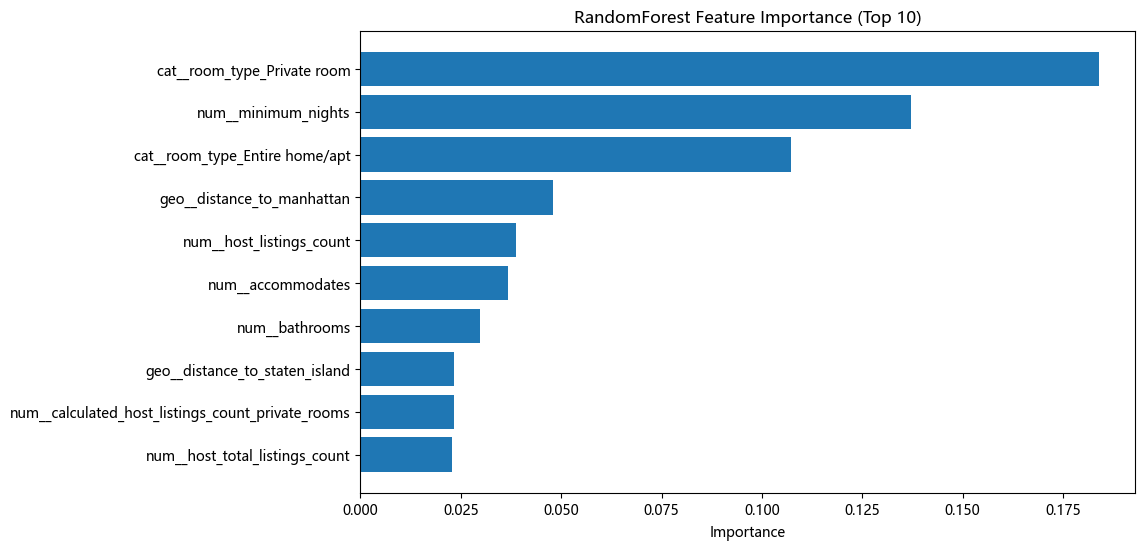

In [72]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_preprocessed, y_train)

# 获取特征重要性
rf_importances = rf_model.feature_importances_
# 创建 DataFrame 并选出前10个特征
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).head(10)
plot_feature_importance(rf_importance_df, 'RandomForest Feature Importance (Top 10)')

D:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:11:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


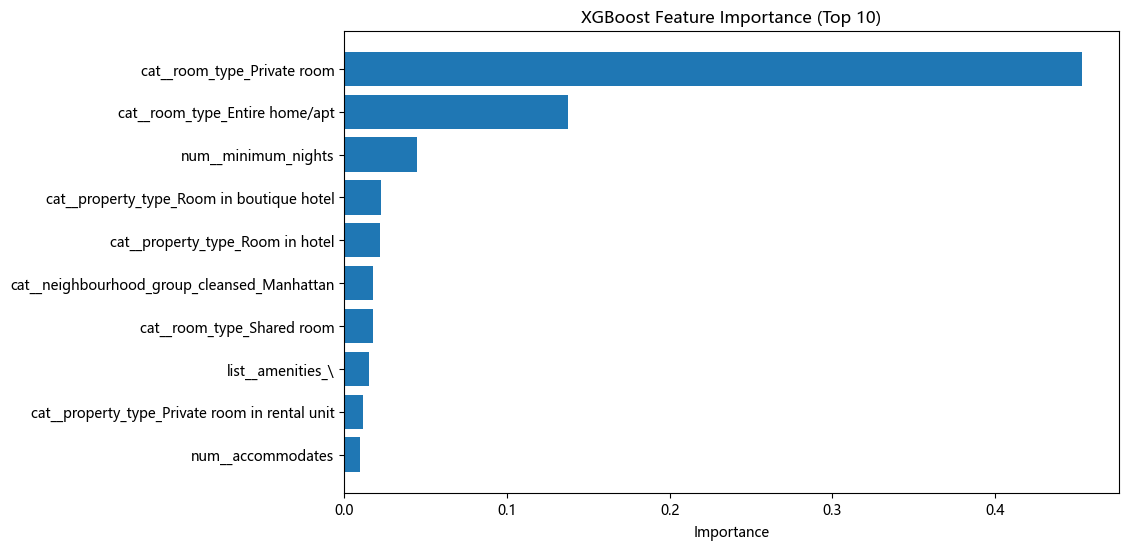

In [74]:
xgb_model = XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse')
xgb_model.fit(X_train_preprocessed, y_train)

# 获取特征重要性
xgb_importances = xgb_model.feature_importances_

# 创建 DataFrame 并选出前10个特征
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False).head(10)
plot_feature_importance(xgb_importance_df, 'XGBoost Feature Importance (Top 10)')

In [94]:
from sklearn.model_selection import RandomizedSearchCV

In [98]:
random_search = RandomizedSearchCV(XGBRegressor(), param, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


D:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:26:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__reg_alpha", "regressor__reg_lambda", "regressor__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__colsample_bytree': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'regressor__max_depth': [3, 5, 7],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 500],
                                        'regressor__reg_alpha': [0, 0.1, 1],
                                        'regressor__reg_lambda': [0.1, 1, 10],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [62]:
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'regressor__subsample': 0.8, 'regressor__reg_lambda': 1, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 500, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 1.0}


In [100]:
cv_results = pd.DataFrame(random_search.cv_results_)

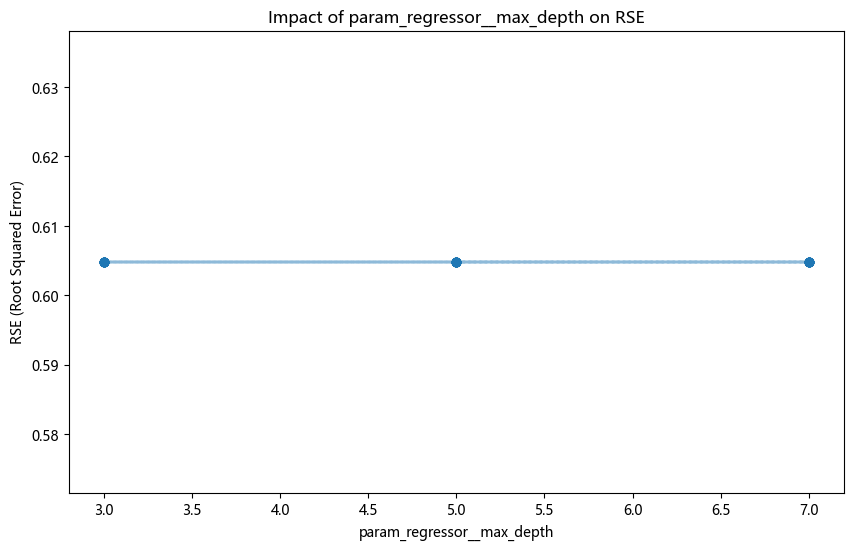

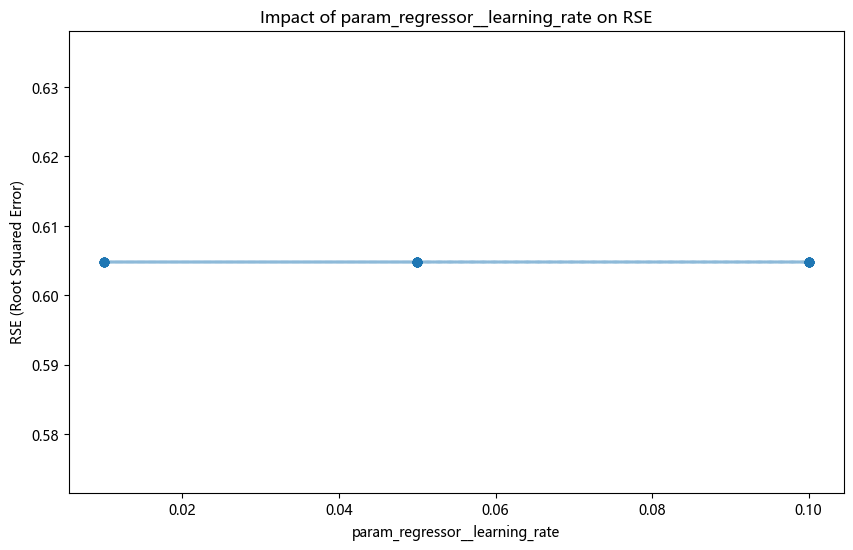

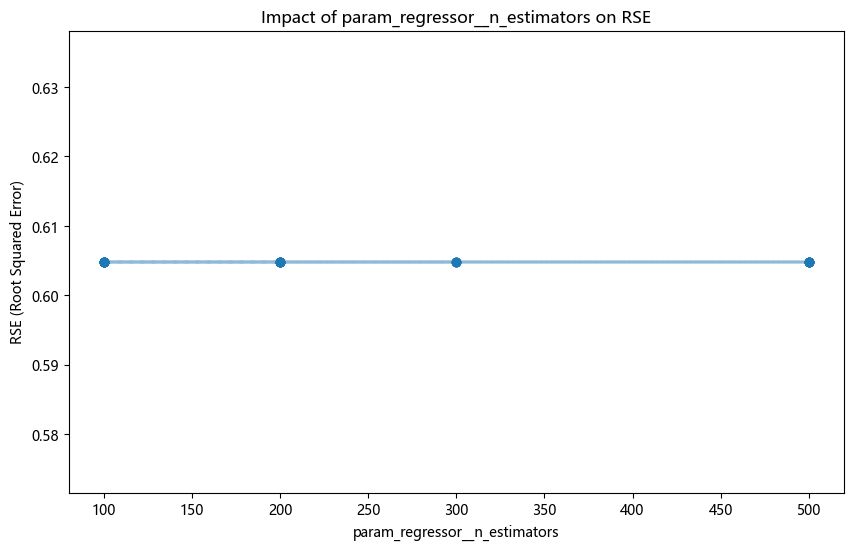

In [112]:
important_params = [
    'param_regressor__max_depth',
    'param_regressor__learning_rate',
    'param_regressor__n_estimators'
]

for param in important_params:
    if param in cv_results:
        plt.figure(figsize=(10, 6))
        plt.scatter(cv_results[param], -cv_results['mean_test_score'], alpha=0.7)
        plt.plot(cv_results[param], -cv_results['mean_test_score'], linestyle='--', alpha=0.5)
        plt.xlabel(param)
        plt.ylabel('RSE (Root Squared Error)')
        plt.title(f'Impact of {param} on RSE')
        plt.show()
    else:
        print(f"Parameter {param} not found in cv_results.")

In [106]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__subsample,param_regressor__reg_lambda,param_regressor__reg_alpha,param_regressor__n_estimators,param_regressor__max_depth,param_regressor__learning_rate,param_regressor__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.207928,0.409153,0.239834,0.009745,0.8,0.1,0.1,300,3,0.01,1.0,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
1,6.510108,0.203096,0.278373,0.038189,0.6,10,0.1,300,3,0.01,0.8,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
2,6.590490,0.156167,0.242502,0.022544,1.0,10,0,500,3,0.05,1.0,"{'regressor__subsample': 1.0, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
3,6.412625,0.338137,0.270561,0.069248,0.6,1,0,100,7,0.01,1.0,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
4,6.215177,0.170227,0.228598,0.010942,0.6,1,1,100,3,0.1,0.8,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
5,6.169659,0.281241,0.217525,0.011526,0.8,10,0,500,5,0.01,0.6,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
6,5.767957,0.120689,0.233356,0.018829,1.0,1,0,100,5,0.05,1.0,"{'regressor__subsample': 1.0, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
7,5.347131,0.129743,0.197508,0.032346,0.6,0.1,1,100,5,0.05,0.6,"{'regressor__subsample': 0.6, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
8,4.896207,0.074189,0.189885,0.014653,1.0,1,0.1,500,5,0.05,1.0,"{'regressor__subsample': 1.0, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1
9,4.860626,0.054789,0.204730,0.038434,0.8,10,1,200,5,0.05,1.0,"{'regressor__subsample': 0.8, 'regressor__reg_...",-0.636487,-0.582055,-0.607087,-0.591879,-0.606715,-0.604845,0.018424,1


In [63]:
y_pred = np.round(random_search.best_estimator_.predict(X_valid))
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

In [70]:
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MSE: 0.59
RMSE: 0.77
MAE: 0.46
R²: 0.80


In [65]:

y_test_pred = random_search.best_estimator_.predict(test)

In [66]:
submission = pd.DataFrame({
    'id': test['id'],  
    'price': np.round(y_test_pred) 
})

In [68]:
submission.to_csv('submission3.csv', index=False)

In [78]:
xgb_tuned = XGBRegressor(**best_params)
xgb_tuned.fit(X_train_preprocessed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [80]:
y_pred_default = np.round(xgb_model.predict(preprocessor.transform(X_valid)))
y_pred_tuned = np.round(xgb_tuned.predict(preprocessor.transform(X_valid)))

In [82]:
metrics_default = {
    "MSE": mean_squared_error(y_valid, y_pred_default),
    "RMSE": np.sqrt(mean_squared_error(y_valid, y_pred_default)),
    "MAE": mean_absolute_error(y_valid, y_pred_default),
    "R2": r2_score(y_valid, y_pred_default)
}

metrics_tuned = {
    "MSE": mean_squared_error(y_valid, y_pred_tuned),
    "RMSE": np.sqrt(mean_squared_error(y_valid, y_pred_tuned)),
    "MAE": mean_absolute_error(y_valid, y_pred_tuned),
    "R2": r2_score(y_valid, y_pred_tuned)
}

In [84]:
print("Default XGBoost Metrics:")
for key, value in metrics_default.items():
    print(f"{key}: {value:.2f}")

print("\nTuned XGBoost Metrics:")
for key, value in metrics_tuned.items():
    print(f"{key}: {value:.2f}")

Default XGBoost Metrics:
MSE: 0.63
RMSE: 0.79
MAE: 0.48
R2: 0.79

Tuned XGBoost Metrics:
MSE: 0.58
RMSE: 0.76
MAE: 0.45
R2: 0.80


In [86]:
tuned_importances = xgb_tuned.feature_importances_
tuned_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tuned_importances
}).sort_values(by='Importance', ascending=False).head(10)

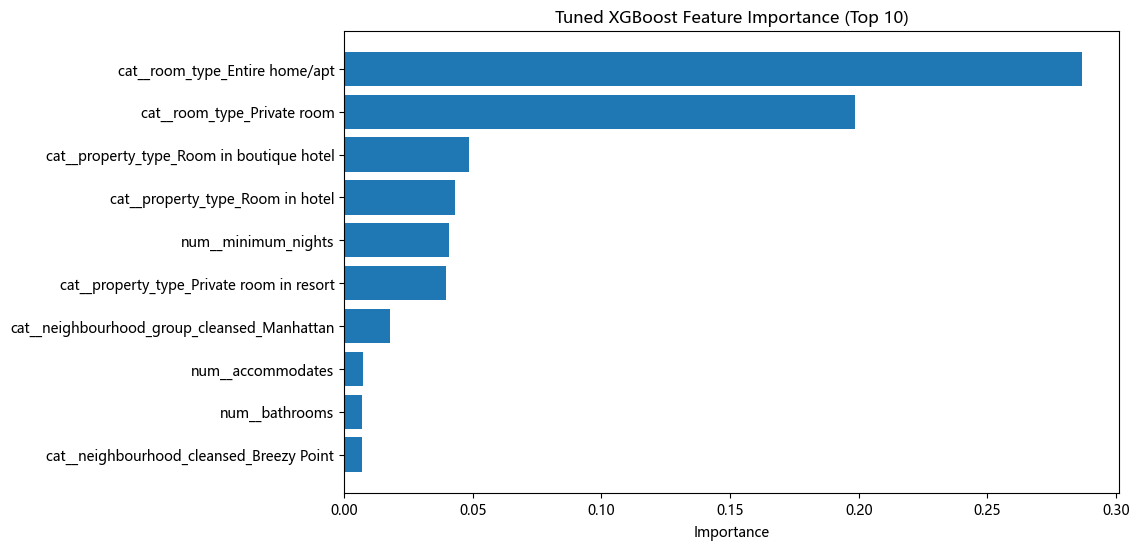

In [90]:
plot_feature_importance(tuned_importance_df, 'Tuned XGBoost Feature Importance (Top 10)')